# Determine the best features using a Logistic Regression Model

## Imports

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    accuracy_score,
)
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from joblib import dump, load

## Find the git root Directory

In [ ]:
# Get the current working directory
cwd = Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

## Import Utilities

In [ ]:
sys.path.append(f"{root_dir}/utils")
import analysis_utils as au
import preprocess_utils as ppu
import eval_utils as eu
import train_utils as tu

# Seed and Generator for Reproducibility

In [ ]:
rnd_val = 0  # Random value for all seeds
rng = np.random.default_rng(seed=rnd_val)  # random number generator

## Create the directory path if non-existent

In [ ]:
fig_out_path = Path(f"{root_dir}/2.evaluate_models/model_performance_figures")

if not fig_out_path.exists():
    fig_out_path.mkdir()

## Load Model

In [ ]:
models_path = Path(
    f"{root_dir}/1.train_models/trained_models_feature_selection/plate3_cp_fs_data"
)

lr = load(models_path / "lr_model.joblib")

## Load Data

In [ ]:
testdf = load(models_path / "testdf.joblib")
le = load(models_path / "label_encoder.joblib")

## Make Predictions

In [ ]:
testdf["preds"] = lr.predict(testdf.drop("label", axis="columns"))

In [1]:
print(f"Accuracy = {accuracy_score(testdf['label'], testdf['preds'])}")

Accuracy = 0.8920377867746289


## Create Dataframe with coefficients for each Genotype

In [ ]:
featdf = testdf.drop(testdf.index)
featdf.drop(["label", "preds"], inplace=True, axis=1)
featdf = featdf.T
featdf = featdf.reset_index()
featdf = featdf.rename(columns={"index": "features"})

In [ ]:
featdf = pd.concat(
    [pd.DataFrame(lr.coef_.T, columns=le.classes_.tolist()), featdf], axis="columns"
)
featdf["abs_HET"] = featdf["HET"].abs()

## Find Confusion Matrix

Installed tk event loop hook.


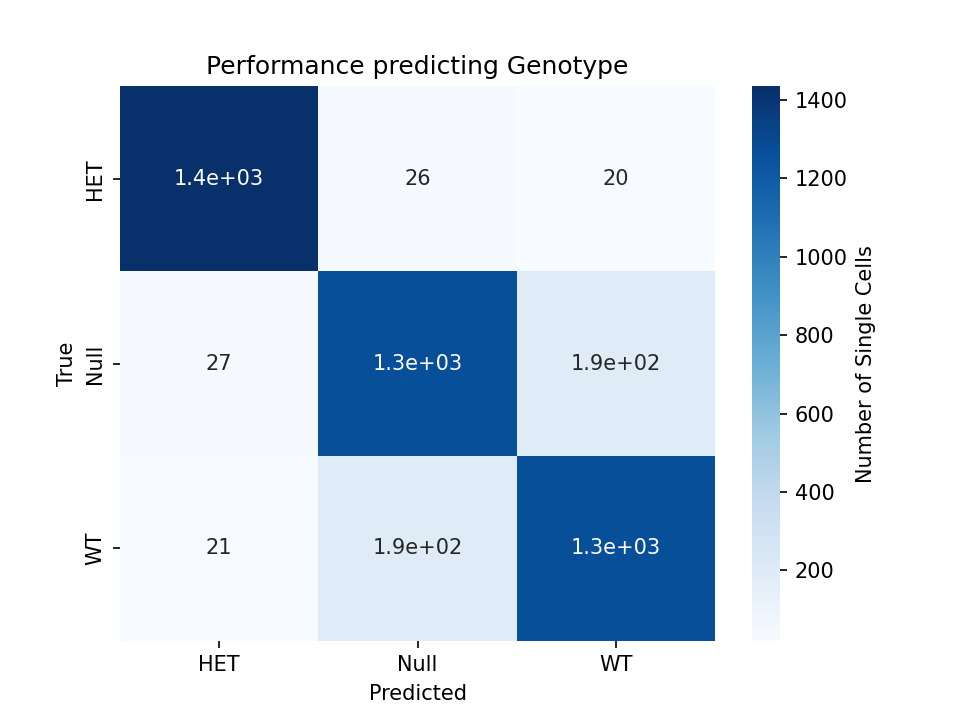

In [2]:
cm3 = pd.crosstab(
    testdf["label"], testdf["preds"], rownames=["True"], colnames=["Predicted"]
)
ax = sns.heatmap(
    cm3,
    annot=True,
    cmap="Blues",
    xticklabels=le.classes_.tolist(),
    yticklabels=le.classes_.tolist(),
)
cbar = ax.collections[0].colorbar
cbar.set_label("Number of Single Cells")
plt.title("Performance predicting Genotype")
plt.savefig(f"{fig_out_path}/lr_conf_mat.png")

In [3]:
print(
    f"The number of incorrectly classified cells is {(cm3.sum() - np.diag(cm3)).sort_values(ascending=False)}"
)

The number of incorrectly classified cells is Predicted
1    219
2    213
0     48
dtype: int64
